In [1]:
from commons import ensemble_error

ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

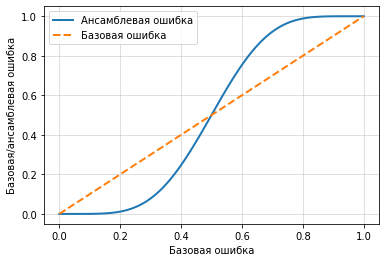

In [2]:
from matplotlib import pyplot as plt
import numpy as np

error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error)
              for error in error_range]
plt.plot(error_range, ens_errors, label='Ансамблевая ошибка', linewidth=2)
plt.plot(error_range, error_range, linestyle='--', label='Базовая ошибка', linewidth=2)
plt.xlabel('Базовая ошибка')
plt.ylabel('Базовая/ансамблевая ошибка')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

In [3]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """Ансамблевый классификатор с мажоритарным голосованием
    Параметры
    ---------
    classifiers : подобен массиву, форма = [n_classifiers]
        Различные классификаторы для ансамбля.
    vote : str, { 'classlabel ', 'probability'}
        По умолчанию: 'classlabel '
        В случае 'classlabel' прогноз основывается
        на результате argmax меток классов. В случае
        'probaЬility' для прогнозирования метки класса
        применяется argmax суммы вероятностей
        (рекомендуется для откалиброванных классификаторов).
    weights : подобен массиву, форма = [n_classifiers]
        Необязательно, по умолчанию: None
        Если предоставляется список значений int или float,
        тогда классификаторам назначаются веса по важности;
        в случае weights=None используются равномерные веса.
    """

    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for
                                  key, value in
                                  _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """Подгоняет классификаторы.
        Параметры
        ---------
        Х : {подобен массиву, разреженная матрица},
            форма = [n_examples, n_features]
            Матрица обучающих образцов.
        у : подобен массиву, форма = [n_examples]
            Вектор целевых меток классов.
        Возвращает
        ----------
        self : object
        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote должно быть 'probability'"
                             "или 'classlabel'; получено (vote=%r)"
                             % self.vote)
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError("Koличecтвo классификаторов и количество весов"
                             "должны быть равны; получено %d весов,"
                             "%d классификаторов" % (len(self.weights),
                                                     len(self.classifiers)))
        # Использовать LabelEncoder для гарантии того,
        # что метки классов начинаются с О;
        # это важно при вызове np.argmax в self.predict.
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """
        Прогнозирует метки классов для Х.
        Параметры
        ---------
        Х : {подобен массиву, разреженная матрица},
            форма = [n_examples, n_features]
            Матрица обучающих образцов.
        Возвращает
        ----------
        maj_vote : {подобен массиву, форма = [n_examples]
            Спрогнозированные метки классов.
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # vote='classlabel'
            # Получить результаты из вызовов clf.predict
            predictions = np.asarray([clf.predict(X)
                                      for clf in
                                      self.classifiers_]).T
            maj_vote = np.apply_along_axis(
                lambda x:
                np.argmax(np.bincount(x, weights=self.weights)),
                axis=1,
                arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """Прогнозирует вероятности классов для Х.
        Параметры
        ---------
        Х : {подобен массиву, разреженная матрица},
        форма = [n_examples, n_features]
        Обучающие векторы, где n_examples - количество
        образцов, а п features - количество признаков.
        Возвращает
        ----------
        avg_proba : подобен массиву,
        форма_= [n_examples, n_classes]
        Взвешенная усредненная вероятность
        для каждого класса на образец.
        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas,
                               axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """Получает имена параметров классификатора для
        решетчатого поиска
        """
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out['%s %s' % (name, key)] = value
            return out

In [4]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

clf1 = LogisticRegression(penalty='l2', C=0.001, solver='lbfgs', random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])
clf_labels = ['Логистическая регрессия', 'Дерево принятия решений', 'КNN']
print('Перекрестная проверка по 10 блокам: \n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print('ROC AUC: %0.2f (+/- %0.2f)[ % s]' % (scores.mean(), scores.std(), label))

Перекрестная проверка по 10 блокам: 

ROC AUC: 0.92 (+/- 0.15)[ Логистическая регрессия]
ROC AUC: 0.87 (+/- 0.18)[ Дерево принятия решений]
ROC AUC: 0.85 (+/- 0.13)[ КNN]


In [6]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Мажоритарное голосование']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.15) [Логистическая регрессия]
ROC AUC: 0.87 (+/- 0.18) [Дерево принятия решений]
ROC AUC: 0.85 (+/- 0.13) [КNN]
ROC AUC: 0.98 (+/- 0.05) [Мажоритарное голосование]


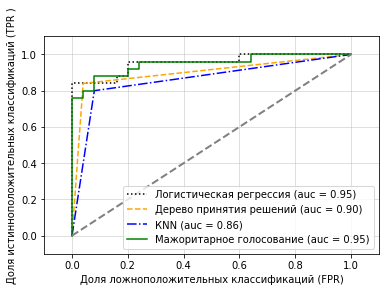

In [7]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    # предполагается, что меткой положительного класса является 1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred, pos_label=2)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc = %0.2f)' % (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('Доля ложноположительных классификаций (FPR)')
plt.ylabel('Доля истинноположительных классификаций (TPR )')
plt.show()

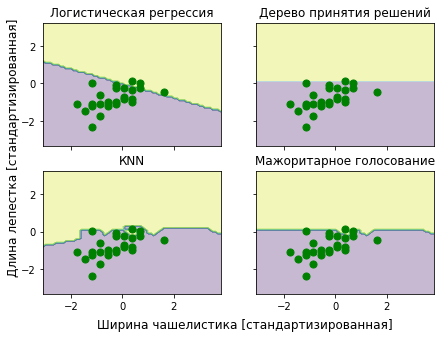

In [8]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(7, 5))
for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 0, 0],
                                  X_train_std[y_train == 0, 1],
                                  c='blue',
                                  marker='^',
                                  s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 1, 0],
                                  X_train_std[y_train == 1, 1],
                                  c='green',
                                  marker='o',
                                  s=50)
    axarr[idx[0], idx[1]].set_title(tt)
plt.text(-3.5, -5., s='Ширина чашелистика [стандартизированная]', ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5, s='Длина лепестка [стандартизированная]', ha='center', va='center', fontsize=12, rotation=90)
plt.show()

In [9]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1 memory': None,
 'pipeline-1 steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1 verbose': False,
 'pipeline-1 sc': StandardScaler(),
 'pipeline-1 clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1 sc__copy': True,
 'pipeline-1 sc__with_mean': True,
 'pipeline-1 sc__with_std': True,
 'pipeline-1 clf__C': 0.001,
 'pipeline-1 clf__class_weight': None,
 'pipeline-1 clf__dual': False,
 'pipeline-1 clf__fit_intercept': True,
 'pipeline-1 clf__intercept_scaling': 1,
 'pipeline-1 clf__l1_ratio': None,
 'pipeline-1 clf__max_iter': 100,
 'pipeline-1 clf__multi_class': 'au